# 3D map simulation: solution of the exercises

## 1. Retrieve the SkyModel parameters with a 3D analysis fit from the simulated dataset

For this exercise, you will do a usual 3D fit with the same model used to simulated the data and see the stability of the simulations. And estimate the signifiance of the source.

Objectives: Often, it is useful to simulate many such datasets and look at the distribution of the reconstructed parameters.

## 2. Using simulations, determine the minimal time to detect significantly an exponential cut-off in the spectrum of a weak source
Estimating the significance of an Exponential Cutoff in the spectrum for each simulation, and change the observation time for each simulation.
The normalisation at 1TeV of the source can be set at "1e-12 cm-2 s-1 TeV-1" and the cut-off energy at 40 TeV.



## Imports and versions

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from gammapy.irf import load_irf_dict_from_file
from gammapy.maps import WcsGeom, MapAxis
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    ExpCutoffPowerLawSpectralModel,
    GaussianSpatialModel,
    SkyModel,
    Models,
    FoVBackgroundModel,
)
from gammapy.makers import MapDatasetMaker, SafeMaskMaker
from gammapy.modeling import Fit
from gammapy.data import Observation, FixedPointingInfo, PointingMode, observatory_locations
from gammapy.datasets import MapDataset
from gammapy.estimators import FluxPointsEstimator
from scipy.stats import chi2
from gammapy.stats.utils import ts_to_sigma
from IPython.core.display import HTML 

## Simulation

We will simulate using the CTA-1DC IRFs shipped with gammapy. Note that for dedictaed CTA simulations, you can simply use [`Observation.from_caldb()`]() without having to externally load the IRFs

In [3]:
# Loading IRFs
irfs = load_irf_dict_from_file("$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits")

Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


In [4]:
# Define the observation parameters (typically the observation duration and the pointing position):
livetime = 10.0 * u.hr
pointing_position = SkyCoord(0, 0, unit="deg", frame="galactic")
pointing = FixedPointingInfo(
    mode=PointingMode.POINTING,
    fixed_icrs=pointing_position.icrs,
)

In [5]:
# Define map geometry for binned simulation
energy_reco = MapAxis.from_edges(
    np.logspace(-1.0, 2.0, 15), unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(6, 6),
    frame="galactic",
    axes=[energy_reco],
)
# It is usually useful to have a separate binning for the true energy axis
energy_true = MapAxis.from_edges(
    np.logspace(-1.5, 2.5, 30), unit="TeV", name="energy_true", interp="log"
)

empty = MapDataset.create(
    geom, name="dataset-simu", energy_axis_true=energy_true
)

In [6]:
# Define sky model to used simulate the data.
# Here we use a Gaussian spatial model and a Power Law spectral model.
spatial_model = GaussianSpatialModel(
    lon_0="0.2 deg", lat_0="0.1 deg", sigma="0.3 deg", frame="galactic"
)
spectral_model = PowerLawSpectralModel(
    index=2.2, amplitude="1e-12 cm-2 s-1 TeV-1", reference="1 TeV"
)
model_simu = SkyModel(
    spatial_model=spatial_model,
    spectral_model=spectral_model,
    name="model-simu",
)

bkg_model = FoVBackgroundModel(dataset_name="dataset-simu")

models = Models([model_simu, bkg_model])
print(models)

Models

Component 0: SkyModel

  Name                      : model-simu
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.200   +/-    0.00             
    amplitude                     :   1.00e-12   +/- 0.0e+00 1 / (TeV s cm2)
    reference             (frozen):      1.000       TeV         
    lon_0                         :      0.200   +/-    0.00 deg         
    lat_0                         :      0.100   +/-    0.00 deg         
    sigma                         :      0.300   +/-    0.00 deg         
    e                     (frozen):      0.000                   
    phi                   (frozen):      0.000       deg         

Component 1: FoVBackgroundModel

  Name                      : dataset-simu-bkg
  Datasets names            : ['dataset-simu']
  Spectral model type       : PowerLawNormSpec

Now, comes the main part of dataset simulation. We create an in-memory observation and an empty dataset. We then predict the number of counts for the given model, and Poission fluctuate it using `fake()` to make a simulated counts maps. Keep in mind that it is important to specify the `selection` of the maps that you want to produce 

In [7]:
# Create an in-memory observation
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

Observation

	obs id            : 0 
 	tstart            : 51544.00
	tstop             : 51544.42
	duration          : 36000.00 s
	pointing (icrs)   : 266.4 deg, -28.9 deg

	deadtime fraction : 0.0%



In [8]:
# Make the MapDataset
maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])

maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=4.0 * u.deg)

dataset = maker.run(empty, obs)
dataset = maker_safe_mask.run(dataset, obs)

In [9]:
%%time

# Add the model on the dataset and Poission fluctuate
dataset.models = models
dataset.fake()
# Do a print on the dataset - there is now a counts maps
print(dataset)

MapDataset
----------

  Name                            : dataset-simu 

  Total counts                    : 811007 
  Total background counts         : 810346.54
  Total excess counts             : 660.46

  Predicted counts                : 812153.07
  Predicted background counts     : 810346.54
  Predicted excess counts         : 1806.52

  Exposure min                    : 2.24e+04 m2 s
  Exposure max                    : 2.06e+11 m2 s

  Number of total bins            : 1260000 
  Number of fit bins              : 1251432 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 289904.19

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 6

  Component 0: SkyModel
  
    Name                      : model-simu
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model type       : 
    Paramet

In [10]:
dataset.counts.geom

WcsGeom

	axes       : ['lon', 'lat', 'energy']
	shape      : (300, 300, 14)
	ndim       : 3
	frame      : galactic
	projection : CAR
	center     : 0.0 deg, 0.0 deg
	width      : 6.0 deg x 6.0 deg
	wcs ref    : 0.0 deg, 0.0 deg

Now use this dataset as you would in all standard analysis. You can plot the maps, or proceed with your custom analysis. 
In the next section, we show the standard 3D fitting as in [analysis_3d](analysis_3d.ipynb).

In [11]:
# To plot, eg, counts:
dataset.counts.smooth(0.2 * u.deg).plot_interactive(
    add_cbar=True, stretch="linear"
)

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

## Exercise 1: fit the simulated dataset

In this section, we do a usual 3D fit with the same model used to simulated the data and see the stability of the simulations. Often, it is useful to simulate many such datasets and look at the distribution of the reconstructed parameters.

In [12]:
models_fit = models.copy()

In [13]:
# We want to fit the background in this case, so we will let the norm free but the spectral index frozen
models_fit["dataset-simu-bkg"].spectral_model.norm.frozen = False
models_fit["dataset-simu-bkg"].spectral_model.tilt.frozen = True

In [14]:
dataset.models = models_fit
print(dataset.models)

DatasetModels

Component 0: SkyModel

  Name                      : model-simu
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.200   +/-    0.00             
    amplitude                     :   1.00e-12   +/- 0.0e+00 1 / (TeV s cm2)
    reference             (frozen):      1.000       TeV         
    lon_0                         :      0.200   +/-    0.00 deg         
    lat_0                         :      0.100   +/-    0.00 deg         
    sigma                         :      0.300   +/-    0.00 deg         
    e                     (frozen):      0.000                   
    phi                   (frozen):      0.000       deg         

Component 1: FoVBackgroundModel

  Name                      : dataset-simu-bkg
  Datasets names            : ['dataset-simu']
  Spectral model type       : PowerLawN

In [15]:
%%time
fit = Fit(optimize_opts={"print_level": 1})
result1 = fit.run(datasets=[dataset])
stat_H1=result1.total_stat

CPU times: user 13.2 s, sys: 44.5 ms, total: 13.2 s
Wall time: 13.3 s


In [16]:
HTML(result1.minuit._repr_html_())

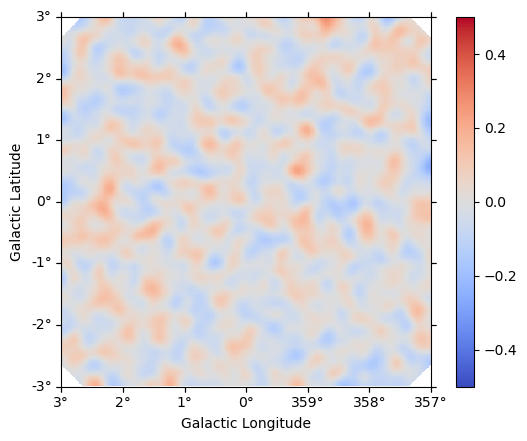

In [17]:
dataset.plot_residuals_spatial(method="diff/sqrt(model)", vmin=-0.5, vmax=0.5);

In [18]:
fpe = FluxPointsEstimator(energy_edges=energy_reco.edges)
flux_points = fpe.run(datasets=[dataset])

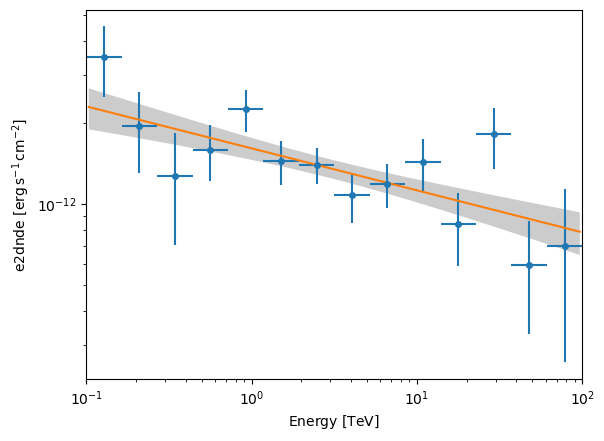

In [19]:
flux_points.plot(sed_type='e2dnde');
models_fit[0].spectral_model.plot([0.1,100]*u.TeV, sed_type='e2dnde');
models_fit[0].spectral_model.plot_error([0.1,100]*u.TeV, sed_type='e2dnde');

Compare the injected and fitted models: 

In [20]:
print(
    "True model: \n",
    model_simu,
    "\n\n Fitted model: \n",
    models_fit["model-simu"],
)

True model: 
 SkyModel

  Name                      : model-simu
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.200   +/-    0.00             
    amplitude                     :   1.00e-12   +/- 0.0e+00 1 / (TeV s cm2)
    reference             (frozen):      1.000       TeV         
    lon_0                         :      0.200   +/-    0.00 deg         
    lat_0                         :      0.100   +/-    0.00 deg         
    sigma                         :      0.300   +/-    0.00 deg         
    e                     (frozen):      0.000                   
    phi                   (frozen):      0.000       deg         

 

 Fitted model: 
 SkyModel

  Name                      : model-simu
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type 

**Estimating the $-2\ln\mathcal(L)$ of null hypothesis**
Fitting the data with just a background model. No source.

In [21]:
dataset.models = bkg_model
result0 = fit.run(datasets=[dataset])
stat_H0=result0.total_stat
print(stat_H0)

290225.0833287652


**Test Statistics of the point source**

In [22]:
delta_ts=-(stat_H1-stat_H0) # standard formula is TS=-2(LogLike1-LogLike0) but default stat in gammapy is -2 log(L)
df = len(result1.models.parameters.free_parameters.names)-len(result0.models.parameters.free_parameters.names)
sigma = ts_to_sigma(delta_ts, df=df)
print(f"The delta_ts  of H1 vs H0: {delta_ts:.3f}, that gives a p-value of {chi2.sf(delta_ts, df)}")
print(f"Converting this to a significance gives: {sigma:.3f} \u03C3")

The delta_ts  of H1 vs H0: 328.830, that gives a p-value of 6.304569184061206e-69
Converting this to a significance gives: 17.547 σ


## Exercise 2: using simulations, determine the minimal time to detect significantly an exponential cut-off in the spectrum of a weak source

In this section, we do a usual 3D fit with the same model used to simulated the data and see the stability of the simulations. Often, it is useful to simulate many such datasets and look at the distribution of the reconstructed parameters.

In [23]:
# Define the pointing
pointing_position = SkyCoord(0, 0, unit="deg", frame="galactic")
pointing = FixedPointingInfo(
    mode=PointingMode.POINTING,
    fixed_icrs=pointing_position.icrs,
)

# Define map geometry for binned simulation
energy_reco = MapAxis.from_edges(np.logspace(-1.0, 2.0, 15), unit="TeV", name="energy", interp="log")
geom = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(6, 6),
    frame="galactic",
    axes=[energy_reco],
)
# It is usually useful to have a separate binning for the true energy axis
energy_true = MapAxis.from_edges(np.logspace(-1.5, 2.5, 30), unit="TeV", name="energy_true", interp="log")

# Define the MapDataset template used for each simulation
empty = MapDataset.create(geom, name="dataset-simu", energy_axis_true=energy_true)

# Define sky model to used simulate the data.
# Here we use a Gaussian spatial model and a Power Law spectral model.
spatial_model = GaussianSpatialModel(lon_0="0.2 deg", lat_0="0.1 deg", sigma="0.3 deg", frame="galactic")
spectral_model = ExpCutoffPowerLawSpectralModel(index=2.2, amplitude="1e-12 cm-2 s-1 TeV-1", reference="1 TeV", 
                                                lambda_=1/40. * u.Unit("TeV-1"))
model_simu = SkyModel(
    spatial_model=spatial_model,
    spectral_model=spectral_model,
    name="model-simu",
)
bkg_model = FoVBackgroundModel(dataset_name="dataset-simu")

models = Models([model_simu, bkg_model])

# Creation of the generic makers
maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])
maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=4.0 * u.deg)

In [24]:
livetime_scan = [1, 5, 10.0, 20.] * u.hr

In [25]:
%%time

results = []
for idx, livetime in enumerate(livetime_scan):
    # Do the simulation
    print(f"Simulation for Livetime = {livetime}")
    obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs, obs_id=idx)
    dataset = maker.run(empty, obs)
    dataset = maker_safe_mask.run(dataset, obs)
    dataset.models = models
    dataset.fake()

    # Do the 3D fit
    models_fit = models.copy()
    spatial_model = models_fit["model-simu"].spatial_model
    spatial_model.lon_0.min = spatial_model.lon_0.value - 0.5
    spatial_model.lon_0.max = spatial_model.lon_0.value + 0.5
    spatial_model.lat_0.min = spatial_model.lat_0.value - 0.5
    spatial_model.lat_0.max = spatial_model.lat_0.value + 0.5
    dataset.models = models_fit
    fit = Fit(optimize_opts={"print_level": 1})
    result1 = fit.run(datasets=[dataset])
    stat_H1=result1.total_stat

    # Do the 3D fit with only the Bkg model
    dataset.models = bkg_model
    result0 = fit.run(datasets=[dataset])
    stat_H0=result0.total_stat

    delta_ts=-(stat_H1-stat_H0)
    df = len(result1.models.parameters.free_parameters.names)-len(result0.models.parameters.free_parameters.names)
    sigma = ts_to_sigma(delta_ts, df=df)

    sp_model = result1.models["model-simu"].spectral_model
    Ec = 1./sp_model.lambda_.quantity
    err = Ec**2 * sp_model.lambda_.error / u.TeV
    result = {
        "livetime": livetime,
        "success": result1.success,
        "ecut": Ec,
        "ecut_err": err,
        "sigma": sigma
    }
    results.append(result)

Simulation for Livetime = 1.0 h
W VariableMetricBuilder Reached machine accuracy limit; Edm 0.000896661 is smaller than machine limit 0.02404 while 0.0002 was requested
Simulation for Livetime = 5.0 h
W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line
W VariableMetricBuilder Matrix not pos.def., try to make pos.def.
W MnPosDef non-positive diagonal element in covariance matrix[ 2 ] = -0.769123
W MnPosDef Added to diagonal of Error matrix a value 1.26912
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Iterations finish without convergence; Edm 25.0539 Requested 0.0002
Simulation for Livetime = 10.0 h
Simulation for Livetime = 20.0 h
W VariableMetricBuilder Reached machine accuracy limit; Edm 0.00189814 is smaller than machine limit 0.101808 while 0.0002 was requested
CPU times: user 1min 45s, sys: 2.85 s, total: 1min 48s
Wall time: 1min 48s


In [26]:
# print(results)

<Figure size 1000x1000 with 0 Axes>

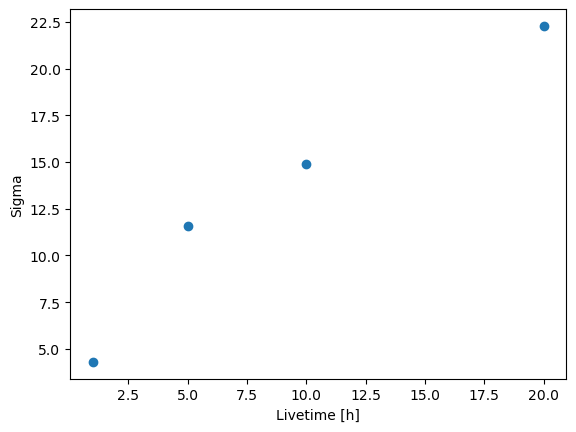

In [27]:
duration = [_['livetime'].to("h").value for _ in results]
sigma = [_['sigma'] for _ in results]

plt.figure(figsize=(10, 10));
fig, ax = plt.subplots();
ax.plot(duration, sigma, marker="o", ls="none");
ax.set_xlabel("Livetime [h]");
ax.set_ylabel("Sigma");

## Going further
- The simulations could be improved by making 100 simulations per observation time and returning the average cutoff energy and its dispersion (RMS)
- When the fit does not converge, one can compute a lower limit on the cutoff energy, ie an upper limit on lambda. In that purpose, one should compute the likelihood profile for fixed values of lambda while leaving free the other parameters
- Simulate a source exhibing a log-normal variable of its flux as a function of time (the tutorial about [the energy-dependent temporal evolution](https://docs.gammapy.org/1.1/tutorials/analysis-3d/event_sampling_nrg_depend_models.html) can be used as exemple) - PS: with the v1.2 of Gammapy, the interface has been simplified